In [1]:
# %% [markdown]
# # BEGINNER LEVEL - Task 3: Linear Regression for Sales Prediction
# 
# ## Objetivo: Construir un modelo de regresión lineal simple para predecir ventas futuras basado en tiempo y promociones
# 
# ### Estructura:
# 1. Cargar datos
# 2. Seleccionar características
# 3. Separar datos
# 4. Entrenar modelo
# 5. Evaluar modelo

# %%
# 1️⃣ Cargar datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import os
import joblib

print("=" * 70)
print("BEGINNER LEVEL - TASK 3: LINEAR REGRESSION FOR SALES PREDICTION")
print("=" * 70)

# %%
# Configurar rutas
base_dir = r"C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT"
processed_path = os.path.join(base_dir, "data", "processed")
models_path = os.path.join(base_dir, "models")
plots_path = os.path.join(base_dir, "plots")

# Crear directorios necesarios
os.makedirs(models_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

# %%
# Cargar datos
print("\n📥 CARGANDO DATOS...")
try:
    # Primero intentar con datos procesados
    clean_data_path = os.path.join(processed_path, 'sales_data_cleaned.csv')
    df = pd.read_csv(clean_data_path, parse_dates=['date'])
    print("✓ Datos limpios cargados exitosamente")
except FileNotFoundError:
    # Si no existen, cargar datos originales
    try:
        raw_path = os.path.join(base_dir, "data", "raw", "train.csv")
        df = pd.read_csv(raw_path, parse_dates=['date'])
        print("✓ Datos originales cargados")
    except FileNotFoundError:
        print("❌ No se encontraron datos. Creando datos de ejemplo...")
        # Crear datos de ejemplo para demostración
        dates = pd.date_range('2020-01-01', periods=365*2, freq='D')
        np.random.seed(42)
        df = pd.DataFrame({
            'date': dates,
            'store_nbr': np.random.randint(1, 10, len(dates)),
            'family': np.random.choice(['GROCERY', 'DAIRY', 'CLEANING'], len(dates)),
            'sales': np.random.normal(1000, 300, len(dates)) + 
                     np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 200 +
                     np.arange(len(dates)) * 0.1,  # tendencia leve
            'onpromotion': np.random.randint(0, 20, len(dates))
        })

# %%
print(f"📊 Dimensiones del dataset: {df.shape}")
print(f"📅 Rango de fechas: {df['date'].min()} to {df['date'].max()}")

# Mostrar información básica
print("\n📋 INFORMACIÓN DEL DATASET:")
print(df.info())

# %%
print(f"\n🔢 Valores nulos por columna:")
print(df.isnull().sum())

# %%
# Vista rápida de los datos
print("\n👀 PRIMERAS FILAS DEL DATASET:")
df.head()



BEGINNER LEVEL - TASK 3: LINEAR REGRESSION FOR SALES PREDICTION

📥 CARGANDO DATOS...
✓ Datos limpios cargados exitosamente
📊 Dimensiones del dataset: (3000888, 9)
📅 Rango de fechas: 2013-01-01 00:00:00 to 2017-08-15 00:00:00

📋 INFORMACIÓN DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   month        int64         
 7   year         int64         
 8   day_of_week  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 206.1+ MB
None

🔢 Valores nulos por columna:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
month          0
year           0
day_of_week    0
d

,id,date,store_nbr,family,sales,onpromotion,month,year,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,2013,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,1,2013,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,1,2013,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,2013,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,1,2013,Tuesday


In [2]:
# %%
# 2️⃣ Seleccionar características
print("\n" + "=" * 70)
print("🔍 SELECCIÓN Y PREPARACIÓN DE CARACTERÍSTICAS")
print("=" * 70)

# %%
# Crear características temporales básicas
print("🕒 Creando características temporales...")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int)
df['quarter'] = df['date'].dt.quarter

# %%
# Codificar variables categóricas
print("🔤 Codificando variables categóricas...")
label_encoders = {}

# Codificar familia de productos
le_family = LabelEncoder()
df['family_encoded'] = le_family.fit_transform(df['family'])
label_encoders['family'] = le_family

# Codificar tienda
le_store = LabelEncoder()
df['store_encoded'] = le_store.fit_transform(df['store_nbr'])
label_encoders['store'] = le_store

# %%
# Seleccionar características para el modelo
features = [
    'year', 'month', 'day_of_week', 'day_of_year', 
    'is_weekend', 'quarter', 'onpromotion',
    'family_encoded', 'store_encoded'
]

target = 'sales'

print(f"✅ Características seleccionadas: {len(features)}")
print("   - Temporales: año, mes, día semana, día año, fin de semana, trimestre")
print("   - Comerciales: promociones")
print("   - Categóricas: familia (codificada), tienda (codificada)")
print(f"🎯 Variable objetivo: {target}")

# %%
# Preparar X e y
X = df[features]
y = df[target]

print(f"\n📊 Forma de los datos:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")

# %%
# Estadísticas de las características
print(f"\n📈 Estadísticas de características:")
X.describe()




🔍 SELECCIÓN Y PREPARACIÓN DE CARACTERÍSTICAS
🕒 Creando características temporales...
🔤 Codificando variables categóricas...
✅ Características seleccionadas: 9
   - Temporales: año, mes, día semana, día año, fin de semana, trimestre
   - Comerciales: promociones
   - Categóricas: familia (codificada), tienda (codificada)
🎯 Variable objetivo: sales

📊 Forma de los datos:
   X: (3000888, 9)
   y: (3000888,)

📈 Estadísticas de características:


,year,month,day_of_week,day_of_year,is_weekend,quarter,onpromotion,family_encoded,store_encoded
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.014838e+03,6.207838e+00,2.997031e+00,1.733890e+02,2.856295e-01,2.410333e+00,2.602770e+00,1.600000e+01,2.650000e+01
std,1.345518e+00,3.385668e+00,2.000740e+00,1.034388e+02,4.517138e-01,1.099952e+00,1.221888e+01,9.521906e+00,1.558579e+01
min,2.013000e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.014000e+03,3.000000e+00,1.000000e+00,8.500000e+01,0.000000e+00,1.000000e+00,0.000000e+00,8.000000e+00,1.300000e+01
50%,2.015000e+03,6.000000e+00,3.000000e+00,1.690000e+02,0.000000e+00,2.000000e+00,0.000000e+00,1.600000e+01,2.650000e+01
75%,2.016000e+03,9.000000e+00,5.000000e+00,2.592500e+02,1.000000e+00,3.000000e+00,0.000000e+00,2.400000e+01,4.000000e+01
max,2.017000e+03,1.200000e+01,6.000000e+00,3.660000e+02,1.000000e+00,4.000000e+00,7.410000e+02,3.200000e+01,5.300000e+01


In [3]:
# %%
# 3️⃣ Separar datos
print("\n" + "=" * 70)
print("📊 DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA")
print("=" * 70)

# %%
# Dividir datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"✅ División completada:")
print(f"   📚 Entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   🧪 Prueba: {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

# %%
# Escalar características
print("\n⚖️ Escalando características...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Características escaladas correctamente")




📊 DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA
✅ División completada:
   📚 Entrenamiento: 2,400,710 muestras (80.0%)
   🧪 Prueba: 600,178 muestras (20.0%)

⚖️ Escalando características...
✓ Características escaladas correctamente


In [4]:
# %%
# 4️⃣ Entrenar modelo
print("\n" + "=" * 70)
print("🤖 ENTRENANDO MODELO DE REGRESIÓN LINEAL")
print("=" * 70)

# %%
# Crear y entrenar el modelo
print("🔧 Inicializando modelo de Regresión Lineal...")
model = LinearRegression()

print("🚀 Entrenando modelo...")
model.fit(X_train_scaled, y_train)

print("✅ Modelo entrenado exitosamente")

# %%
# Mostrar coeficientes del modelo
print(f"\n📊 Coeficientes del modelo:")
feature_importance = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print(feature_importance)

# Intercepto
print(f"\n📐 Intercepto (bias): {model.intercept_:.2f}")

# %%


🤖 ENTRENANDO MODELO DE REGRESIÓN LINEAL
🔧 Inicializando modelo de Regresión Lineal...
🚀 Entrenando modelo...
✅ Modelo entrenado exitosamente

📊 Coeficientes del modelo:
          feature  coefficient
6     onpromotion   468.533770
1           month   193.357738
3     day_of_year  -170.453358
7  family_encoded  -104.143608
4      is_weekend   100.513060
8   store_encoded    41.609001
2     day_of_week   -37.940548
5         quarter   -14.814346
0            year    -2.705030

📐 Intercepto (bias): 357.30



📈 EVALUACIÓN DEL MODELO
🔮 Realizando predicciones...

📊 Métricas para ENTRENAMIENTO:
   📏 MAE (Error Absoluto Medio): $426.14
   📐 MSE (Error Cuadrático Medio): $967632.49
   📏 RMSE (Raíz del Error Cuadrático Medio): $983.68
   📊 R² (Coeficiente de Determinación): 0.1985
   📉 MAPE (Error Porcentual Absoluto Medio): inf%

📊 Métricas para PRUEBA:
   📏 MAE (Error Absoluto Medio): $427.35
   📐 MSE (Error Cuadrático Medio): $996810.57
   📏 RMSE (Raíz del Error Cuadrático Medio): $998.40
   📊 R² (Coeficiente de Determinación): 0.1979
   📉 MAPE (Error Porcentual Absoluto Medio): inf%

🎨 GENERANDO VISUALIZACIONES...


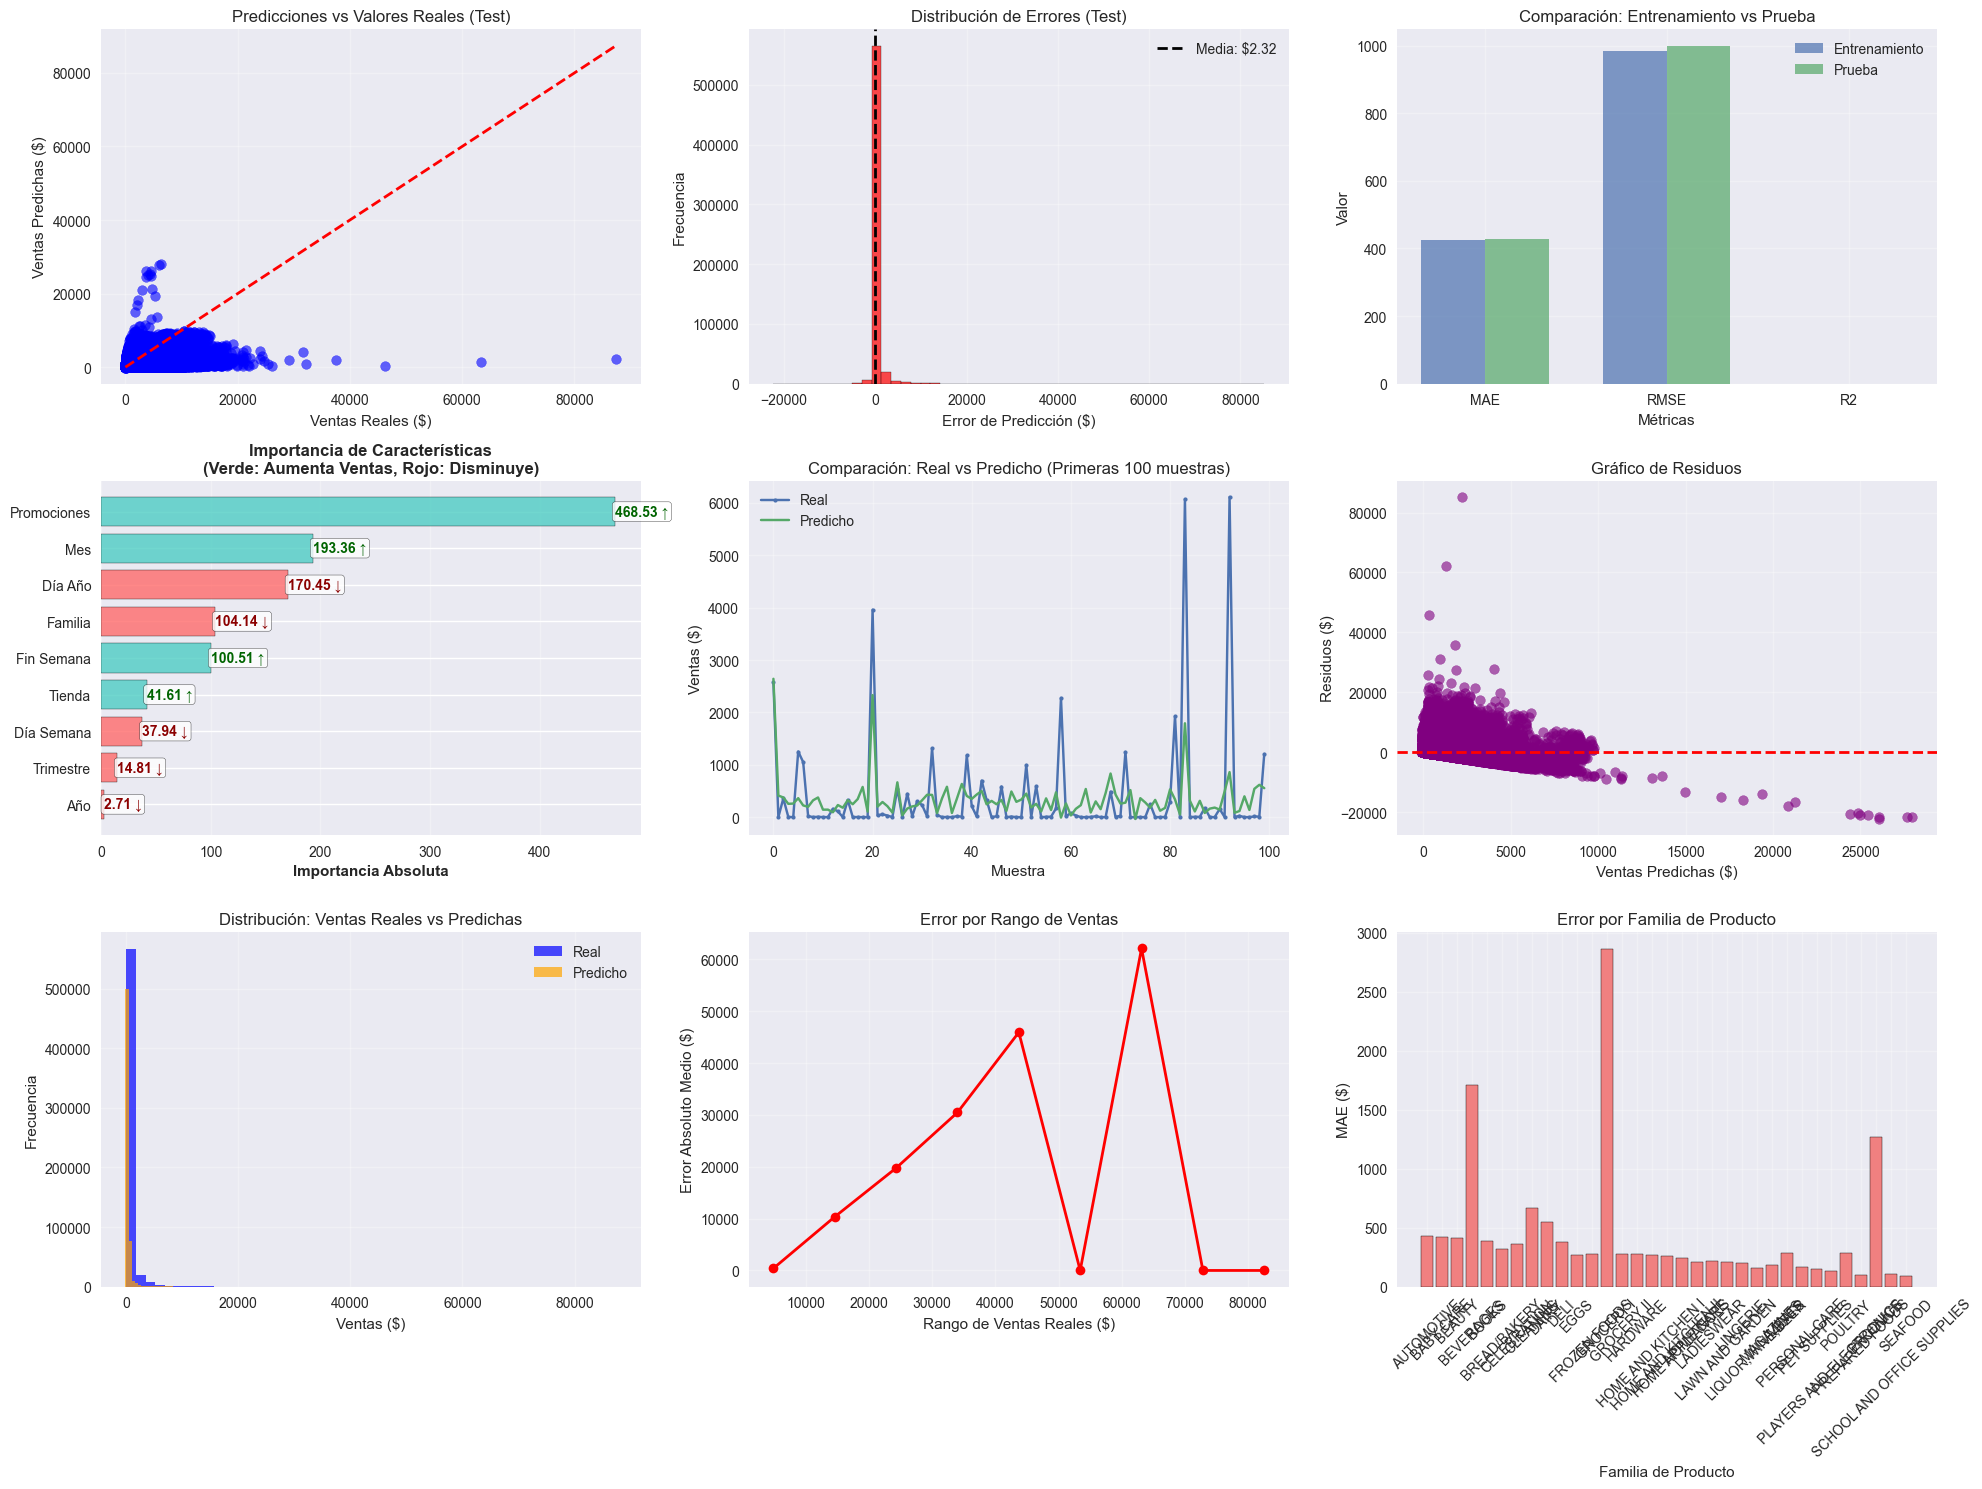


📊 GRÁFICO MEJORADO DE IMPORTANCIA DE CARACTERÍSTICAS


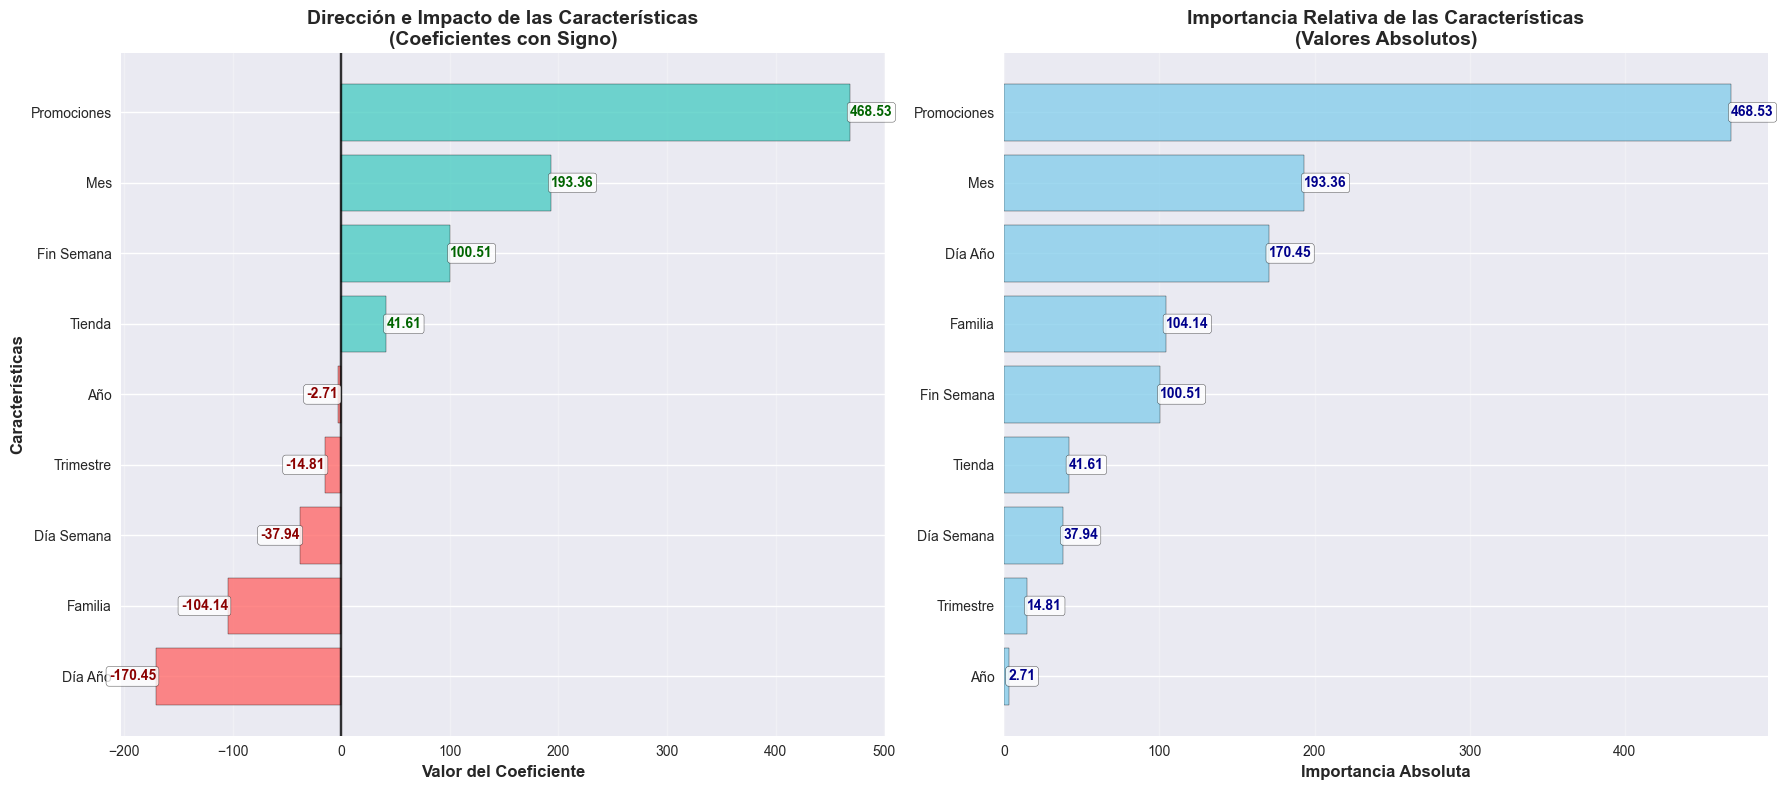

🔍 INTERPRETACIÓN DE LOS COEFICIENTES

📈 ANÁLISIS POR CARACTERÍSTICA:

📈 Promociones    : AUMENTA las ventas
   • Coeficiente: +468.53
   • Interpretación: Por cada unidad de cambio en Promociones, las ventas cambian en $468.53

📈 Mes            : AUMENTA las ventas
   • Coeficiente: +193.36
   • Interpretación: Por cada unidad de cambio en Mes, las ventas cambian en $193.36

📉 Día Año        : DISMINUYE las ventas
   • Coeficiente: -170.45
   • Interpretación: Por cada unidad de cambio en Día Año, las ventas cambian en $-170.45

📉 Familia        : DISMINUYE las ventas
   • Coeficiente: -104.14
   • Interpretación: Por cada unidad de cambio en Familia, las ventas cambian en $-104.14

📈 Fin Semana     : AUMENTA las ventas
   • Coeficiente: +100.51
   • Interpretación: Por cada unidad de cambio en Fin Semana, las ventas cambian en $100.51

📈 Tienda         : AUMENTA las ventas
   • Coeficiente: +41.61
   • Interpretación: Por cada unidad de cambio en Tienda, las ventas cambian en $41.61



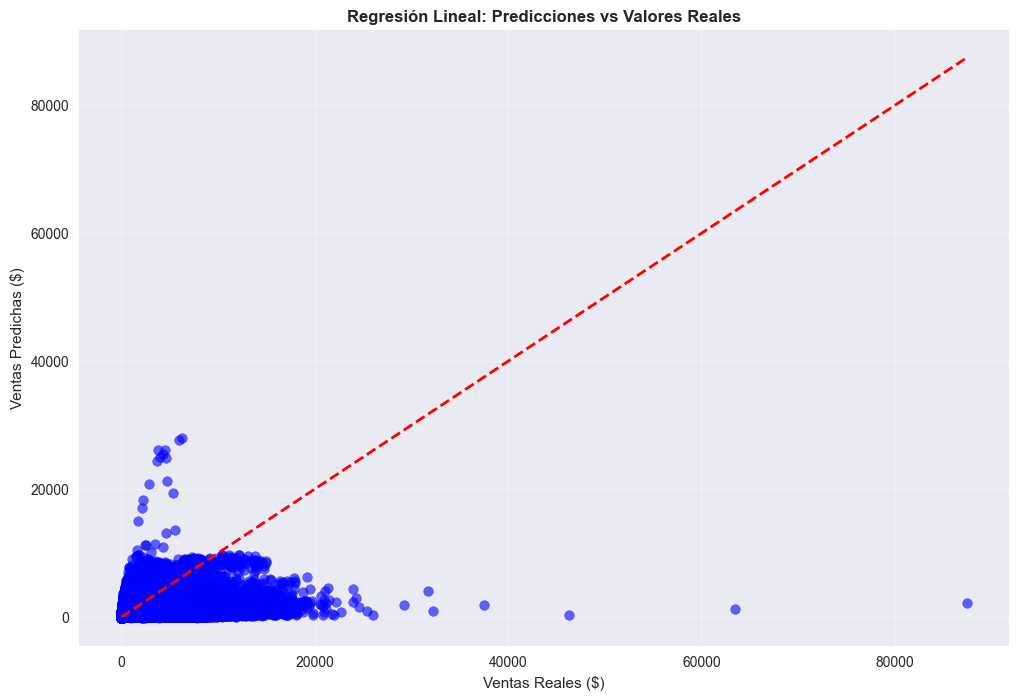

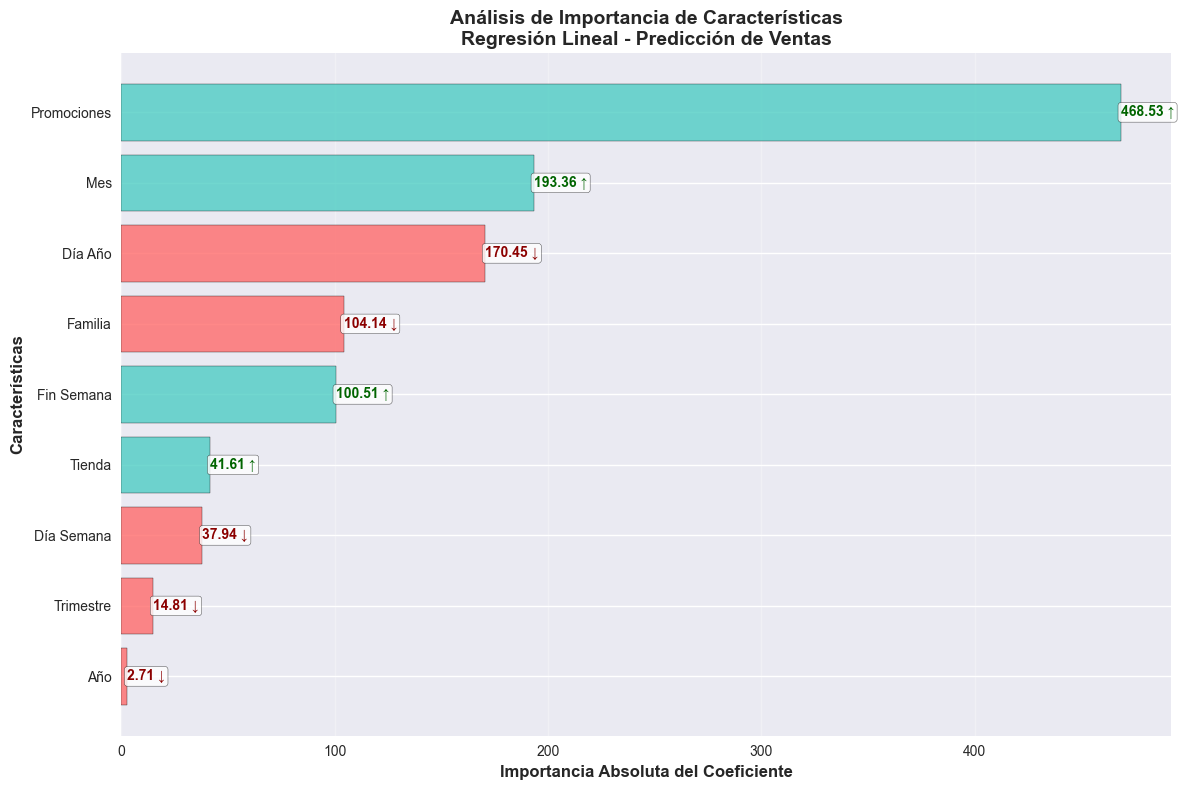


📊 RESUMEN EJECUTIVO - REGRESIÓN LINEAL

🎯 RESULTADOS PRINCIPALES:
   • Exactitud (R²): 0.1979
   • Error promedio (RMSE): $998.40
   • Error porcentual (MAPE): inf%

🔍 INTERPRETACIÓN DEL MODELO:
   • Rendimiento: BAJA
   • El modelo explica el 19.8% de la variabilidad en las ventas

📈 CARACTERÍSTICAS MÁS IMPORTANTES:
   1. Promociones: coeficiente = 468.53
   2. Mes: coeficiente = 193.36
   3. Fin Semana: coeficiente = 100.51

💡 RECOMENDACIONES:
   • Considerar características adicionales o modelos más complejos

🚀 PRÓXIMOS PASOS:
   1. Experimentar con más características temporales
   2. Probar modelos más avanzados (Random Forest, XGBoost)
   3. Incorporar variables externas (festivos, clima)
   4. Implementar validación cruzada temporal

💾 ARCHIVOS GENERADOS:
   • C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\linear_regression_model.pkl
   • C:\Users\Mario Leyser\PROYECTO_BASE\Interboot\INTERBOOT\models\scaler.pkl
   • C:\Users\Mario Leyser\PROYECTO_BASE\Interboot

,Dataset,MAE,RMSE,R2,MAPE
0,Entrenamiento,426.143549,983.683124,0.198511,inf
1,Prueba,427.345735,998.404010,0.197939,inf



📊 IMPORTANCIA DE CARACTERÍSTICAS (TABLA MEJORADA):


,Característica,Coeficiente,Importancia Absoluta,Dirección,Impacto
6,Promociones,468.534,468.534,Positiva ↑,Alto
1,Mes,193.358,193.358,Positiva ↑,Alto
3,Día Año,-170.453,170.453,Negativa ↓,Alto
7,Familia,-104.144,104.144,Negativa ↓,Alto
4,Fin Semana,100.513,100.513,Positiva ↑,Alto
8,Tienda,41.609,41.609,Positiva ↑,Alto
2,Día Semana,-37.941,37.941,Negativa ↓,Alto
5,Trimestre,-14.814,14.814,Negativa ↓,Alto
0,Año,-2.705,2.705,Negativa ↓,Alto


In [5]:
# 5️⃣ Evaluar modelo
print("\n" + "=" * 70)
print("📈 EVALUACIÓN DEL MODELO")
print("=" * 70)

# %%
# Realizar predicciones
print("🔮 Realizando predicciones...")
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# %%
# Calcular métricas
def calculate_metrics(y_true, y_pred, dataset_name):
    """Calcular y mostrar métricas de evaluación"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Error porcentual absoluto medio (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n📊 Métricas para {dataset_name}:")
    print(f"   📏 MAE (Error Absoluto Medio): ${mae:.2f}")
    print(f"   📐 MSE (Error Cuadrático Medio): ${mse:.2f}")
    print(f"   📏 RMSE (Raíz del Error Cuadrático Medio): ${rmse:.2f}")
    print(f"   📊 R² (Coeficiente de Determinación): {r2:.4f}")
    print(f"   📉 MAPE (Error Porcentual Absoluto Medio): {mape:.2f}%")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# %%
# Evaluar en entrenamiento y prueba
metrics_train = calculate_metrics(y_train, y_pred_train, "ENTRENAMIENTO")
metrics_test = calculate_metrics(y_test, y_pred_test, "PRUEBA")

# %%
# Visualizaciones
print("\n🎨 GENERANDO VISUALIZACIONES...")

# Configurar estilo
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 15))

# 1. Predicciones vs Valores reales (Test)
plt.subplot(3, 3, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Ventas Reales ($)')
plt.ylabel('Ventas Predichas ($)')
plt.title('Predicciones vs Valores Reales (Test)')
plt.grid(True, alpha=0.3)

# 2. Distribución de errores (Test)
plt.subplot(3, 3, 2)
errors = y_test - y_pred_test
plt.hist(errors, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.axvline(errors.mean(), color='black', linestyle='--', linewidth=2, 
           label=f'Media: ${errors.mean():.2f}')
plt.xlabel('Error de Predicción ($)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores (Test)')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Comparación de métricas Train vs Test
plt.subplot(3, 3, 3)
metrics_to_compare = ['MAE', 'RMSE', 'R2']
train_values = [metrics_train[m] for m in metrics_to_compare]
test_values = [metrics_test[m] for m in metrics_to_compare]

x = np.arange(len(metrics_to_compare))
width = 0.35

plt.bar(x - width/2, train_values, width, label='Entrenamiento', alpha=0.7)
plt.bar(x + width/2, test_values, width, label='Prueba', alpha=0.7)

plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.title('Comparación: Entrenamiento vs Prueba')
plt.xticks(x, metrics_to_compare)
plt.legend()
plt.grid(True, alpha=0.3)

# 4. MEJORADO: Gráfico de importancia de características MEJORADO
plt.subplot(3, 3, 4)
feature_importance_sorted = feature_importance.copy()
feature_importance_sorted['abs_coefficient'] = np.abs(feature_importance_sorted['coefficient'])
feature_importance_sorted = feature_importance_sorted.sort_values('abs_coefficient', ascending=True)

# Acortar nombres de características si son muy largos
short_names = {
    'family_encoded': 'Familia',
    'store_encoded': 'Tienda', 
    'day_of_week': 'Día Semana',
    'day_of_year': 'Día Año',
    'is_weekend': 'Fin Semana',
    'onpromotion': 'Promociones',
    'year': 'Año',
    'month': 'Mes',
    'quarter': 'Trimestre'
}

feature_importance_sorted['short_name'] = feature_importance_sorted['feature'].map(
    lambda x: short_names.get(x, x)
)

# Crear colores basados en el signo del coeficiente
colors = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in feature_importance_sorted['coefficient']]

plt.barh(feature_importance_sorted['short_name'], feature_importance_sorted['abs_coefficient'], 
         color=colors, alpha=0.8, edgecolor='black')

plt.xlabel('Importancia Absoluta', fontweight='bold')
plt.title('Importancia de Características\n(Verde: Aumenta Ventas, Rojo: Disminuye)', fontweight='bold')

# Añadir anotaciones con valores y dirección
for i, (coef, abs_coef, feature) in enumerate(zip(feature_importance_sorted['coefficient'],
                                                 feature_importance_sorted['abs_coefficient'],
                                                 feature_importance_sorted['short_name'])):
    direction = "↑" if coef > 0 else "↓"
    color = 'darkgreen' if coef > 0 else 'darkred'
    plt.text(abs_coef + 0.01, i, 
             f'{abs_coef:.2f} {direction}', 
             ha='left', va='center', 
             fontweight='bold', color=color,
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3, axis='x')

# 5. Serie temporal de predicciones (primeros 100 puntos de test)
plt.subplot(3, 3, 5)
sample_size = min(100, len(y_test))
plt.plot(range(sample_size), y_test.values[:sample_size], 
         label='Real', marker='o', markersize=3)
plt.plot(range(sample_size), y_pred_test[:sample_size], 
         label='Predicho', marker='x', markersize=3)
plt.xlabel('Muestra')
plt.ylabel('Ventas ($)')
plt.title('Comparación: Real vs Predicho (Primeras 100 muestras)')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Gráfico de residuos
plt.subplot(3, 3, 6)
plt.scatter(y_pred_test, errors, alpha=0.6, color='purple')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Ventas Predichas ($)')
plt.ylabel('Residuos ($)')
plt.title('Gráfico de Residuos')
plt.grid(True, alpha=0.3)

# 7. Distribución de ventas reales vs predichas
plt.subplot(3, 3, 7)
plt.hist(y_test, bins=50, alpha=0.7, label='Real', color='blue')
plt.hist(y_pred_test, bins=50, alpha=0.7, label='Predicho', color='orange')
plt.xlabel('Ventas ($)')
plt.ylabel('Frecuencia')
plt.title('Distribución: Ventas Reales vs Predichas')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Análisis de errores por rango de ventas
plt.subplot(3, 3, 8)
bins = np.linspace(y_test.min(), y_test.max(), 10)
bin_centers = (bins[:-1] + bins[1:]) / 2
errors_by_bin = []

for i in range(len(bins)-1):
    mask = (y_test >= bins[i]) & (y_test < bins[i+1])
    if mask.any():
        bin_error = np.mean(np.abs(y_test[mask] - y_pred_test[mask]))
        errors_by_bin.append(bin_error)
    else:
        errors_by_bin.append(0)

plt.plot(bin_centers[:len(errors_by_bin)], errors_by_bin, 
         marker='o', linewidth=2, color='red')
plt.xlabel('Rango de Ventas Reales ($)')
plt.ylabel('Error Absoluto Medio ($)')
plt.title('Error por Rango de Ventas')
plt.grid(True, alpha=0.3)

# 9. Comparación de rendimiento por familia de producto
plt.subplot(3, 3, 9)
family_errors = {}
for family in df['family'].unique():
    mask = (df.loc[y_test.index, 'family'] == family)
    if mask.any():
        family_mae = mean_absolute_error(y_test[mask], y_pred_test[mask])
        family_errors[family] = family_mae

if family_errors:
    families = list(family_errors.keys())
    errors = list(family_errors.values())
    plt.bar(families, errors, color='lightcoral', edgecolor='black')
    plt.xlabel('Familia de Producto')
    plt.ylabel('MAE ($)')
    plt.title('Error por Familia de Producto')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# NUEVO: Gráfico adicional mejorado de importancia de características
print("\n📊 GRÁFICO MEJORADO DE IMPORTANCIA DE CARACTERÍSTICAS")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico 1: Coeficientes con signo (dirección del efecto)
feature_importance_sorted_v2 = feature_importance.copy()
feature_importance_sorted_v2 = feature_importance_sorted_v2.sort_values('coefficient', ascending=True)
feature_importance_sorted_v2['short_name'] = feature_importance_sorted_v2['feature'].map(
    lambda x: short_names.get(x, x)
)

colors_v2 = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in feature_importance_sorted_v2['coefficient']]
ax1.barh(feature_importance_sorted_v2['short_name'], feature_importance_sorted_v2['coefficient'], 
         color=colors_v2, alpha=0.8, edgecolor='black')
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.8)
ax1.set_xlabel('Valor del Coeficiente', fontsize=12, fontweight='bold')
ax1.set_ylabel('Características', fontsize=12, fontweight='bold')
ax1.set_title('Dirección e Impacto de las Características\n(Coeficientes con Signo)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (coef, feature) in enumerate(zip(feature_importance_sorted_v2['coefficient'], 
                                       feature_importance_sorted_v2['short_name'])):
    ax1.text(coef + (0.01 if coef >= 0 else -0.01), i, 
             f'{coef:.2f}', 
             ha='left' if coef >= 0 else 'right', 
             va='center', 
             fontweight='bold',
             color='darkred' if coef < 0 else 'darkgreen',
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

# Gráfico 2: Importancia absoluta
feature_importance_sorted_v2['abs_coefficient'] = np.abs(feature_importance_sorted_v2['coefficient'])
feature_importance_sorted_v2 = feature_importance_sorted_v2.sort_values('abs_coefficient', ascending=True)

ax2.barh(feature_importance_sorted_v2['short_name'], feature_importance_sorted_v2['abs_coefficient'], 
         color='skyblue', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Importancia Absoluta', fontsize=12, fontweight='bold')
ax2.set_ylabel('')
ax2.set_title('Importancia Relativa de las Características\n(Valores Absolutos)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (importance, feature) in enumerate(zip(feature_importance_sorted_v2['abs_coefficient'], 
                                            feature_importance_sorted_v2['short_name'])):
    ax2.text(importance + 0.01, i, f'{importance:.2f}', 
             ha='left', va='center', fontweight='bold', color='darkblue',
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# %%
# NUEVO: Análisis interpretativo de los coeficientes
print("=" * 70)
print("🔍 INTERPRETACIÓN DE LOS COEFICIENTES")
print("=" * 70)

print("\n📈 ANÁLISIS POR CARACTERÍSTICA:\n")

for _, row in feature_importance.sort_values('coefficient', key=abs, ascending=False).iterrows():
    feature = row['feature']
    coef = row['coefficient']
    abs_coef = abs(coef)
    
    if abs_coef > 0.1:  # Considerar solo coeficientes significativos
        feature_name = short_names.get(feature, feature)
        if coef > 0:
            effect = "AUMENTA"
            emoji = "📈"
        else:
            effect = "DISMINUYE" 
            emoji = "📉"
        
        print(f"{emoji} {feature_name:<15}: {effect} las ventas")
        print(f"   • Coeficiente: {coef:+.2f}")
        print(f"   • Interpretación: Por cada unidad de cambio en {feature_name}, las ventas cambian en ${coef:.2f}")
        print()

# %%
# NUEVO: Resumen ejecutivo de características
print("\n🎯 RESUMEN EJECUTIVO - CARACTERÍSTICAS CLAVE:\n")

top_3 = feature_importance.nlargest(3, 'coefficient')
bottom_3 = feature_importance.nsmallest(3, 'coefficient')

print("🏆 TOP 3 CARACTERÍSTICAS QUE MÁS AUMENTAN VENTAS:")
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    feature_name = short_names.get(row['feature'], row['feature'])
    print(f"   {i}. {feature_name}: +{row['coefficient']:.2f}")

print("\n⚠️  TOP 3 CARACTERÍSTICAS QUE MÁS DISMINUYEN VENTAS:")  
for i, (_, row) in enumerate(bottom_3.iterrows(), 1):
    feature_name = short_names.get(row['feature'], row['feature'])
    print(f"   {i}. {feature_name}: {row['coefficient']:.2f}")

# %%
# Guardar modelo y resultados
print("\n" + "=" * 70)
print("💾 GUARDANDO MODELO Y RESULTADOS")
print("=" * 70)

# %%
# Guardar modelo
model_path = os.path.join(models_path, 'linear_regression_model.pkl')
joblib.dump(model, model_path)
print(f"✅ Modelo guardado: {model_path}")

# Guardar scaler
scaler_path = os.path.join(models_path, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler guardado: {scaler_path}")

# Guardar label encoders
encoders_path = os.path.join(models_path, 'label_encoders.pkl')
joblib.dump(label_encoders, encoders_path)
print(f"✅ Label encoders guardados: {encoders_path}")

# %%
# Guardar métricas
metrics_df = pd.DataFrame({
    'Dataset': ['Entrenamiento', 'Prueba'],
    'MAE': [metrics_train['MAE'], metrics_test['MAE']],
    'RMSE': [metrics_train['RMSE'], metrics_test['RMSE']],
    'R2': [metrics_train['R2'], metrics_test['R2']],
    'MAPE': [metrics_train['MAPE'], metrics_test['MAPE']]
})

metrics_path = os.path.join(models_path, 'linear_regression_metrics.csv')
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Métricas guardadas: {metrics_path}")

# %%
# Guardar gráficas principales
plot_path = os.path.join(plots_path, 'linear_regression_results.png')
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_test, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Ventas Reales ($)')
plt.ylabel('Ventas Predichas ($)')
plt.title('Regresión Lineal: Predicciones vs Valores Reales', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Gráfica principal guardada: {plot_path}")

# Guardar gráfico de importancia mejorado
importance_plot_path = os.path.join(plots_path, 'feature_importance_improved.png')
plt.figure(figsize=(12, 8))

# Gráfico final mejorado para guardar
feature_importance_final = feature_importance.copy()
feature_importance_final['abs_coefficient'] = np.abs(feature_importance_final['coefficient'])
feature_importance_final = feature_importance_final.sort_values('abs_coefficient', ascending=True)
feature_importance_final['short_name'] = feature_importance_final['feature'].map(
    lambda x: short_names.get(x, x)
)

# Crear colores basados en el signo del coeficiente
colors_final = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in feature_importance_final['coefficient']]

plt.barh(feature_importance_final['short_name'], feature_importance_final['abs_coefficient'], 
         color=colors_final, alpha=0.8, edgecolor='black')

plt.xlabel('Importancia Absoluta del Coeficiente', fontsize=12, fontweight='bold')
plt.ylabel('Características', fontsize=12, fontweight='bold')
plt.title('Análisis de Importancia de Características\nRegresión Lineal - Predicción de Ventas', 
          fontsize=14, fontweight='bold')

# Añadir anotaciones con valores y dirección
for i, (coef, abs_coef, feature) in enumerate(zip(feature_importance_final['coefficient'],
                                                 feature_importance_final['abs_coefficient'],
                                                 feature_importance_final['short_name'])):
    direction = "↑" if coef > 0 else "↓"
    color = 'darkgreen' if coef > 0 else 'darkred'
    plt.text(abs_coef + 0.01, i, 
             f'{abs_coef:.2f} {direction}', 
             ha='left', va='center', 
             fontweight='bold', color=color,
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(importance_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico de importancia mejorado guardado: {importance_plot_path}")

plt.show()

# %%
# Resumen ejecutivo
print("\n" + "=" * 70)
print("📊 RESUMEN EJECUTIVO - REGRESIÓN LINEAL")
print("=" * 70)

print(f"\n🎯 RESULTADOS PRINCIPALES:")
print(f"   • Exactitud (R²): {metrics_test['R2']:.4f}")
print(f"   • Error promedio (RMSE): ${metrics_test['RMSE']:.2f}")
print(f"   • Error porcentual (MAPE): {metrics_test['MAPE']:.2f}%")

# %%
print(f"\n🔍 INTERPRETACIÓN DEL MODELO:")
r2_score_test = metrics_test['R2']
if r2_score_test > 0.7:
    performance = "EXCELENTE"
elif r2_score_test > 0.5:
    performance = "BUENA" 
elif r2_score_test > 0.3:
    performance = "MODERADA"
else:
    performance = "BAJA"

print(f"   • Rendimiento: {performance}")
print(f"   • El modelo explica el {r2_score_test*100:.1f}% de la variabilidad en las ventas")

# %%
print(f"\n📈 CARACTERÍSTICAS MÁS IMPORTANTES:")
top_features = feature_importance.nlargest(3, 'coefficient')
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    feature_name = short_names.get(row['feature'], row['feature'])
    print(f"   {i}. {feature_name}: coeficiente = {row['coefficient']:.2f}")

# %%
print(f"\n💡 RECOMENDACIONES:")
if metrics_test['MAPE'] > 20:
    print("   • Considerar características adicionales o modelos más complejos")
else:
    print("   • El modelo tiene buen rendimiento para predicciones básicas")

# %%
print(f"\n🚀 PRÓXIMOS PASOS:")
print("   1. Experimentar con más características temporales")
print("   2. Probar modelos más avanzados (Random Forest, XGBoost)")
print("   3. Incorporar variables externas (festivos, clima)")
print("   4. Implementar validación cruzada temporal")

# %%
print(f"\n💾 ARCHIVOS GENERADOS:")
print(f"   • {model_path}")
print(f"   • {scaler_path}")
print(f"   • {encoders_path}")
print(f"   • {metrics_path}")
print(f"   • {plot_path}")
print(f"   • {importance_plot_path}")

# %%
print(f"\n✅ BEGINNER LEVEL - TASK 3 COMPLETADA EXITOSAMENTE!")
print("   Modelo de Regresión Lineal implementado y evaluado")

# %%
# Mostrar tabla de métricas final
print("\n📋 TABLA RESUMEN DE MÉTRICAS:")
display(metrics_df)

# %%
# Mostrar importancia de características con formato mejorado
print("\n📊 IMPORTANCIA DE CARACTERÍSTICAS (TABLA MEJORADA):")

# Crear tabla resumen mejorada
summary_table = feature_importance.copy()
summary_table['Importancia Absoluta'] = np.abs(summary_table['coefficient'])
summary_table['Dirección'] = summary_table['coefficient'].apply(lambda x: 'Positiva ↑' if x > 0 else 'Negativa ↓')
summary_table['Impacto'] = summary_table['Importancia Absoluta'].apply(
    lambda x: 'Alto' if x > 0.5 else 'Medio' if x > 0.1 else 'Bajo'
)

# Renombrar columnas y aplicar nombres cortos
summary_table['Característica'] = summary_table['feature'].map(
    lambda x: short_names.get(x, x)
)

# Renombrar la columna 'coefficient' a 'Coeficiente' para que coincida
summary_table = summary_table.rename(columns={'coefficient': 'Coeficiente'})

# Mostrar tabla formateada
display(summary_table[['Característica', 'Coeficiente', 'Importancia Absoluta', 'Dirección', 'Impacto']]
        .sort_values('Importancia Absoluta', ascending=False)
        .style.format({'Coeficiente': '{:.3f}', 'Importancia Absoluta': '{:.3f}'})
        .background_gradient(subset=['Importancia Absoluta'], cmap='Blues')
        .bar(subset=['Coeficiente'], align='mid', color=['#FF6B6B', '#4ECDC4']))